# Project 2: Segmentation

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Setting up PyMaxFlow: <span style="color:red;">5 Minutes</span>
* 2. Getting your first successful segmentation: <span style="color:red;">3 hours</span>
* 3. Adjusting parameters (e.g. $\lambda$, $\sigma$) and so forth, to get good results: <span style="color:red;">5 hours</span>
* 4. Completing the write-up: <span style="color:red;">1 hour</span>

Note that there are two folds within the project.  We have provided some images for you to use in testing your implementation, in the `provided images` folder along with their ground-truth segmentations to compare your results to.  Along with these, we want you to provide 2-4 additional images that you select on which you show your results.  <i>Please use the `provided_images` in that path and place any others in the `user_data` folder, and load all of the images (or user input point location files) via the approapriate relative path.  We will drop your notebook file and your `user_data` folder into our folder (which will have the `provided_images` already) and then run your notebook.</i>




## Preparation:
So that you can focus on the elements of the cost function ( the link weights), you may use a existing implementation of the actual min-cut algorithm itself.  You set up the graph, but it will take care of finding the minimum cut.

For this assignment we will be using a python library called PyMaxFlow.  This library is a python wrapper around the original C++ implementation of the min-cut code from [Vladimir Kolmogorov](http://pub.ist.ac.at/%7Evnk/software.html) (who has co-authored several papers on this subject).    

Note: For windows users, you will need the Visual C++ compiler in order for PyMaxFlow to work.  If you already have Visual Studio, this shouldn't be a problem but if you just want the compiler without Visual Studio, you can download [Build Tools For Visual Studio 2017](https://visualstudio.microsoft.com/downloads/#build-tools-for-visual-studio-2017). Once you have access to the Visual C++ compiler look at the next paragraph for PyMaxFlow installation.

PyMaxFlow requires Cython, which should come standard in your anaconda environment but the command to install that will also be included.  To install PyMaxFlow enter the following commands replacing "YourEnvironmentName" with the name of your anaconda environment.
~~~
conda activate YourEnvironemntName
conda install cython
pip install pymaxflow
~~~
Once PyMaxFlow is installed, to understand how to use the library, there is a great [tutorial page](http://pmneila.github.io/PyMaxflow/tutorial.html) that shows how to get started with some simple examples.  Do the "first example" and perhaps the "binary image restoration" as well.

## Annotations:
Graph cut segmentation is an interactive algorithm requiring the user to provide foreground and background seeds.  Provided is a python file that will open a gui and allow you to annotate the image.  This gui is optional and will require additional packages to be installed into your environment.  To install the packages open a terminal and enter the following commands:
~~~
conda activate YourEnvironmentName
conda install scikit-image pillow
~~~
You can use the gui in the following way:
```python
import guiseg
fore, back = guiseg.get_fore_back(image)
image[fore]  # the foreground seeds
image[back]  # the background seeds
```


## Graph Cut:
Your code should read in an image and a set of seed pixels and use graph-cut segmentation to segment the image.

You will need to calculate the costs for the t-links (region terms) and the n-links (boundary terms). See the book, the notes/slides, or published papers in this area for ideas of how to define these.  Remember that the t-link weights to a particular terminal (foreground or background) should be large if that pixel looks a lot like the respective foreground/background seeds. The n-link weights should be large if the two neighboring pixels are similar.

Here is [the original paper on graph-cut segmentation](http://www.csd.uwo.ca/~yuri/Papers/iccv01.pdf), which might help with some ideas, but you should look at the literature to see what other costs functions / link weights others have used.

Once the graph is built, use the min-cut algorithm to partition the graph into nodes connected to the foreground node or to the background node, then use these as the resulting labels for the segmentation. Display this result graphically in some fashion overlaid on the input image.  It is best to start with simple images whose foreground and background colors are pretty different and for ones where the edges are pretty clear.  Graph-cut segmentation struggles sometimes with long, thin structures, so you should avoid these types of images early on.



In [280]:
# Implementation Here (feel free to add additional cells of course)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import guiseg
import maxflow
import scipy.linalg as la
import sklearn.neighbors.kde
import os


def generate_seed(file_name):
    """Takes the name of a file and generates the seeds from user input
    Params:
        file_name (str) : the name of the file to generate user input of foreground and background (ex: "Banana.png")
    Returns:
        seed (dict) : {"name":(foreground_mask,background_mask)}
    """
    seeds = {}
    if file_name in os.listdir("provided_images"):
        folder = "provided_images"
    else:
        folder = "user_data"
    path = folder + "/" +  file_name
    name = file_name[:-4]
    image = cv2.imread(path)[:,:,::-1]
    fore,back = guiseg.get_fore_back(image)
    seeds.setdefault(name, [fore,back])
    return seeds

def create_new_seeds():
    """Creates new seeds for each of the images in the specified folders"""
    for image_folder in ["provided_images", "user_data"]:
        files = [file for file in os.listdir(image_folder) if any((file.endswith(".jpg"), file.endswith(".png")))]
        for file in files:
            name = file[:-4]
            seeds = generate_seed(file)
            np.save("user_data/" + name + "_userpoints", seeds[name])

def create_new_seed(file_name):
    """Creates a new seed for the specific file and saves it to the user_data folder"""
    name = file_name[:-4]
    seeds = generate_seed(file_name)
    np.save("user_data/" + name + "_userpoints", seeds[name])

def load_seeds():
    """Loads all the current user-input seeds that are contained in the user_data folder and returns them
    Returns:
        seeds (dict) : A dictionary with key [name], and value [(foreground,background)]
    """
    image_folder = "user_data"
    files = [file for file in os.listdir(image_folder) if file.endswith("_userpoints.npy")]
    seeds = {}
    for file in files:
        name = file[:-15]
        seed = np.load(image_folder + "/" + file)
        seeds.setdefault(name, [tuple(seed[0]), tuple(seed[1])])
    return seeds

def generate_trimap(file_name, seeds):
    """Takes the name of a file and generates its trimap from user input in seeds dict.
    Params:
        file_name (str) : the name of the file to generate a trimap of. (ex: "Banana.png")
        seeds (dict) : the user input of seeds for the foreground and the background
    Returns:
        new_image (image) : the generated trimap image
    """
    if file_name in os.listdir("provided_images"):
        folder = "provided_images"
    else:
        folder = "user_data"
    name = file_name[:-4]
    path = folder + "/" +  file_name
    image = cv2.imread(path)[:,:,::-1]
    
    #Make the foreground white, the background black and the undetermined gray
    new_image = np.ones_like(image) * 128
    new_image[seeds[name][0]] = 255
    new_image[seeds[name][1]] = 0
    return new_image
    
def compute_boundary_weights(image_diff):
    """Computes the boundary weights, penalizing pixels that are more dissimilar in color.
    
    Here the two parameters sigma and lambda are the following:
      - Sigma corresponds to what is considered a good neighbor. The higher the sigma value, 
        the more different pixel colors can be and still be considered good neighbors.
    
      - Lambda corresponds to how much you weigh neighbor connections compared to t-link (region) connections. 
        "Do you care more about the actual colors that are present or more about connected regions?""
    """
    sigma = 1200
    my_lambda = 20
    return my_lambda * np.exp(-1*la.norm(image_diff,axis=2)**2 / (2*sigma**2))

def compute_pixel_weights(image,name,seeds):
    """Computes the weight of each pixel in the image to whether it should be part of the foreground or background 
    using Kernel Density Estimation of the user-input seed"""
    #Compare each pixel to the distribution of the foreground seed to compute a pixel weight    
    foreground_kde = sklearn.neighbors.kde.KernelDensity()
    l = foreground_kde.fit(image[seeds[name][0]])
    foreground_weights = foreground_kde.score_samples(image.reshape(-1,3))
    foreground_weights = foreground_weights.reshape(image.shape[:2])
    #Compare each pixel the the background seed's distribution and compute its relative probability
    background_kde = sklearn.neighbors.kde.KernelDensity()
    p = background_kde.fit(image[seeds[name][1]])
    background_weights = background_kde.score_samples(image.reshape(-1,3))
    background_weights = background_weights.reshape(image.shape[:2])
    
    return foreground_weights, background_weights

def generate_segmented_image(file_name,seeds):
    """Generates a segmented image of the file passed in. Constructs a graph of the image, computes neighbor weights and terminal 
    weights for each pixel, and applies the min-cut/maxflow algorithm to create an image with the foreround/background identified"""
    image = cv2.imread(file_name)[:,:,::-1]
    folder, name = file_name.split('/')
    graph = maxflow.Graph[float]()
    nodeids = graph.add_grid_nodes(image.shape[:2])
    
    #Compute the right and left  and up and down boundary
    right_diff = image[:,:-1,:] - image[:,1:,:]
    down_diff = image[:-1,:,:] - image[1:,:,:]
        
    #Compute the edge weights for the n-links for (x,y)'s neighbors, (n-links)
    horiz_weights = compute_boundary_weights(right_diff)
    vert_weights = compute_boundary_weights(down_diff)
    horiz_struct = np.array([[0,0,0],[0,0,1],[0,0,0]])
    vert_struct = np.array([[0,0,0],[0,0,0],[0,1,0]])
    
    #Add boundary edges (n-links)
    graph.add_grid_edges(nodeids[:,:-1],horiz_weights, structure=horiz_struct, symmetric=True)
    graph.add_grid_edges(nodeids[:-1,:],vert_weights, structure=vert_struct, symmetric=True)
    
    #Compute the Pixel weights (t-links)
    foreground_weights, background_weights = compute_pixel_weights(image, name[:-4],seeds)
    #Consider foreground_weights[fore] = SOME VALUE to make it a better estimate
    
    #Add pixel weights (t-links)
    graph.add_grid_tedges(nodeids,foreground_weights, background_weights)
    
    #Use maxflow to perform the graph cut - minimum cut/maxflow on the graph we built & return the segmented image
    g = graph.maxflow()
    segments = graph.get_grid_segments(nodeids)
    
    return np.logical_not(segments)  


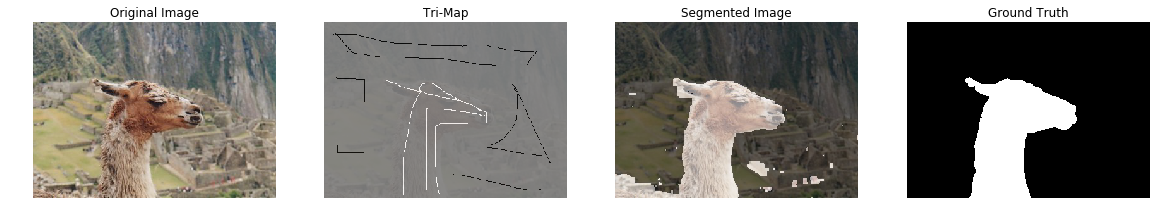

In [282]:
# ****UNCOMMENT ONE OF THESE TO SEE THE SEGMENTATION RESULTS UP CLOSE****
plt.rcParams['figure.figsize'] = [20,10]

# create_new_seed("zebra.jpg")
# display_results("zebra.jpg")
# display_results("banana.png", True)
display_results("llama.jpg",True)
# display_results("penguin.png",True)
# display_results("teddy.png",True)
# display_results("simplecircle.png")
# display_results("peppers.jpg")
# display_results("manhole_cover.jpg")
# display_results("frog.jpg")
# display_results("wings.jpg")

In [230]:
# ONLY RUN IF YOU WANT TO CREATE NEW SEEDS FOR EACH IMAGE!!!
# create_new_seeds()

In [268]:
# Generate results Here (again, add additional cells to your heart's content)
def display_results(file_name, GT=False):
    """Processes the given image and displays the image segmentation results of applying a min-cut approach"""
    name = file_name[:-4]
    if file_name in os.listdir("provided_images"):
        pi_path = "provided_images/" + file_name
    else:
        pi_path = "user_data/" + file_name
    
    original = cv2.imread(pi_path)[:,:,::-1]
    seeds = load_seeds()
    trimap = generate_trimap(file_name, seeds)   
    segmented_image = generate_segmented_image(pi_path,seeds)
    
    plt.subplot(1,4,1)
    plt.title("Original Image")
    plt.axis("off")
    plt.imshow(original)

    plt.subplot(1,4,2)
    plt.title("Tri-Map")
    plt.axis("off")
    plt.imshow(trimap)
    plt.imshow(original, alpha=0.1)

    plt.subplot(1,4,3)
    plt.title("Segmented Image")
    plt.axis("off")
    plt.imshow(segmented_image, cmap = "gray")
    plt.imshow(original, alpha=0.5, cmap = "gray")

    if GT:
        gt_path = "provided_images/ground_truth/" + name + "-seg.png"
        ground_truth = cv2.imread(gt_path)[:,:,::-1]
    
        plt.subplot(1,4,4)
        plt.title("Ground Truth")
        plt.axis("off")
        plt.imshow(ground_truth)

        
def display_all_images():
    """Displays the results for all images in the specified folders"""
    files = [file for file in (os.listdir("provided_images") +os.listdir("user_data")) if any((file.endswith(".jpg"), file.endswith(".png")))]    
    n_files = len(files)
    #Initialize the image to be shown in position 1
    image_num = 1
    #Display the results for each image
    for file_name in files:
        name = file_name[:-4]
        if file_name in os.listdir("provided_images"):
            pi_path = "provided_images/" + file_name
            if file_name != "simplecircle.png":
                GT = True
            else:
                GT = False
        else:
            pi_path = "user_data/" + file_name
            GT = False
            
        original = cv2.imread(pi_path)[:,:,::-1]
        seeds = load_seeds()
        trimap = generate_trimap(file_name, seeds)   
        segmented_image = generate_segmented_image(pi_path,seeds)
        
        plt.subplot(n_files,4,image_num)
        plt.title("Original Image")
        plt.axis("off")
        plt.imshow(original)
        image_num +=1

        plt.subplot(n_files,4,image_num)
        plt.title("Tri-Map")
        plt.axis("off")
        plt.imshow(trimap)
        plt.imshow(original, alpha=0.1)
        image_num +=1

        plt.subplot(n_files,4,image_num)
        plt.title("Segmented Image")
        plt.axis("off")
        plt.imshow(segmented_image, cmap = "gray")
        plt.imshow(original, alpha=0.5, cmap = "gray")
        image_num +=1
        
        #If there is an image with the ground truth, we display it as well
        if GT:
            gt_path = "provided_images/ground_truth/" + name + "-seg.png"
            ground_truth = cv2.imread(gt_path)[:,:,::-1]
            plt.subplot(n_files,4,image_num)
            plt.title("Ground Truth")
            plt.axis("off")
            plt.imshow(ground_truth) 
            
        image_num +=1

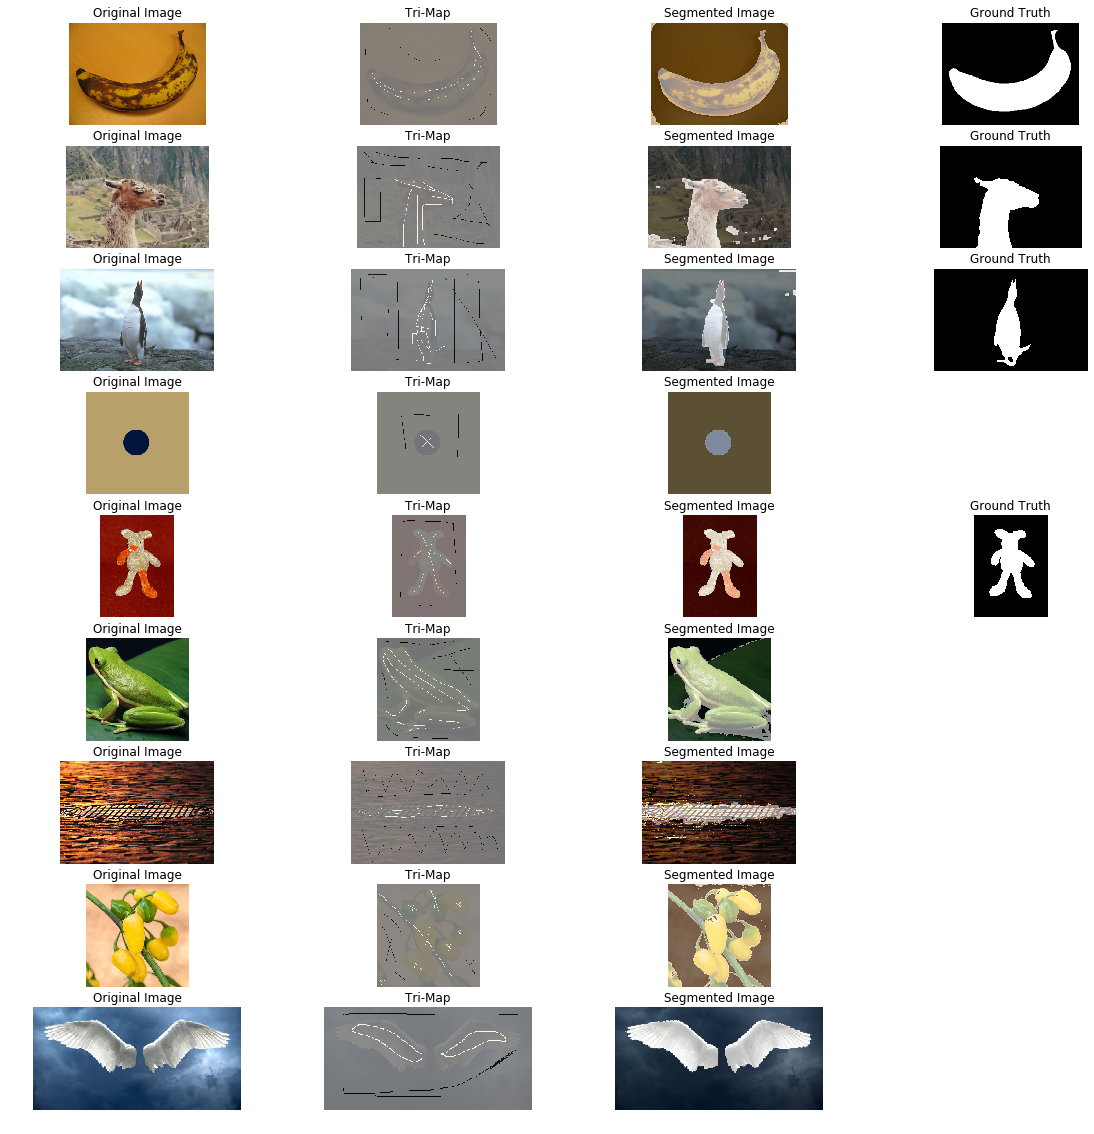

In [260]:
#DISPLAY EACH IMAGE, ITS TRIMAP (FROM THE SEED) AND ITS SEGMENTATION RESULT (ALONG WITH GROUND TRUTH IF IT EXISTS) 
plt.rcParams['figure.figsize'] = [20,20]
display_all_images()


## Grading / Rubric
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly generates the graph network structure (nodes, n-links, t-links).
* [10 pts] Code that produces the boundary term $B(p,q)$ used for n-links.
* [10 pts] Code that produces the region term of the cost $R(p,A)$ used for the t-links.  Remember that you have t-links per pixel, one with cost determined by matching $p$ with the foreground appearance distribution, the other determined relative to the background distribution.  You may use the [sk-learn implementation](https://scikit-learn.org/stable/modules/density.html#kernel-density-estimation) of Kernel Density Estimation.  However you will receive 10 extra points if you implement it yourself.
* [20 pts] Implementing the graph-cut with `pymaxflow` and finding the optimal solution for the input graph.
* [10 pts] Displaying Results in the following format (for each input image you'll show the following 3-4 result images):
   1. Original Image.
   2. Tri-map of what was selected by the user (white for foreground, black for background, gray for unknown).  This can be overlaid on top of a faint copy of the image for context if desired.
   3. Final segmentation.  Again you can overlay it on a faint copy of the original for context.
   4. On the <i>provided images</i> please show a comparison of your resulting segmentaiton with the ground truth.
* [20 pts] Good (certainly not perfect, some of them are challenging, but decent/reasonable) results on the 4 provided images (banana, llama, penguin, teddy).  Each image will receive up to 5 points.
* [10 pts] Demonstrating your algorithm on 2-4 additional images.  At least one of the images should be somewhat easy, one should be somewhat challenging -- expalin why you think they're respectively easy/challenging.


## Write-up:
Provide an explanation for the following items:
* Describe how you determinied/computed the n-link and t-link weights.
* What kinds of image does graph cut segmentation work well for? What kinds of images do you find it struggles with?
* What did you learn from the project?
* What if any suggestions do you have for improving it (for future students)?

<span style="color:red;">WRITE-UP HERE</span>
<p>In order to compute the n-links, which were the boundary terms between pixels, I took the normed difference in color between neighboring pixels, both left and right, and up and down (by subtracting the image from itself shifted in right and down). I used the formula we talked about in class to raise that normed difference in a negative exponent so that larger differences would result in a lower weight and thus more likely to get cut. I divided my normed difference by sigma which allowed me to control the closeness of pixel color. I then multiplied these weights I computed by lambda before adding them to the graph so that the energy would satisfy E(A) = R(A) + lambda * B(A).
To compute the t-link terms, which are the weights of the pixels being assigned to either the foreground or the background, I used SK-Learn's implementation of Kernel Density Estimation. This allowed me to compare each pixel to the distribution of color in the user-input seed labels. This found the probability that the pixel was the color that it was, given it could've come from the two distributions, and these weights I added as the foreground and background weights for each pixel as t-links to my graph.</p>

<p>Graph cut segmentation works well when there is a sharp contrast and definitely recognizeable foreground and background for an image. I found it was pretty good at being able to associate similar colored pixels and pixels that were close together of the same color. I found that it struggled when there were a lot of hues of the same color (as in the llama or manhole cover images), when there were shadows, or if the foreground image had lots of noise on its edges.</p>

<p>For the additional images that I picked, I decided to pick two that were easier and two that were harder. The two easier ones were the wings and the peppers. I thought these were a little easier because there is sharp contrast between the foreground and background. The two harder ones that I picked were a frog and a manhole cover. I felt that the frog would be harder because it was on a green leaf, and wondered if the algorithm would be able to differentiate between them. The manhole cover was definitely the hardest one that I picked because the foreground and background are a lot closer in color to each other and there is a lot of shadows that causes it to mislabel certain parts. It takes a long time to run since it's a larger image, (which is why I saved my segmented version separately in case it's taking too long), but it was able to pick out most of the manhole cover from among the bricks.</p>

<p>I really enjoyed this project, and felt like I learned a lot about the basics of image segmentation. I also learned about how the minimum cut/maximum flow algorithm works and I feel like implementing it helped me to understand it a lot better. I learned about kernel density estimation, and how we can use that to generate probabilities using priors. It was helpful to see that application of Bayesian statistics that I learned about in a different class. I also really liked being able to pick our own images and trying out our implementation on our own choice of things. It gave me more pride in my work, and helped me see that my work is applicable to things outside of pre-defined and verified examples. I also grew in my knowledge of python packages, ins and outs of file access and display. I think one thing that would make this project go a bit smoother is if pymaxflow were better documented. That was a little rough at the beginning since I couldn't really figure it out until having to talk through it with a TA. However, I did feel like what we talked about in class was good enough preparation to be able to figure it out as we worked at it, which is what I think is most important.</p>
